# Algorithm Benchmarking with QASM Simulations

The purpose of this notebook is to evaluate the performance of the implemented quantum time evolution algorithm. The common evaluated criteria are circuit depth and state fidelity. For QASM simulations, the metrics to be evaluated are

> 1. **Circuit depth**
> 1. **Trace distance**

In this notebooks, data is generated using Qiskit, and analyzed to find an expected relation between _evolution time_, _expected fidelity_ and _number of integration steps_. So first, It is wise to start with a little summary about the general results of quantum time evolution as presented by [1], then proceed to demonstrate how to use the devised routines for simulating a generic spin graph, and finally, produce some plots that show the actual performance of the programmed algorithm.

## General Quantum Time Simulation Theory

In this project, a second order Trotter scheme is proposed to estimate evolution of a spin system. Consider a Hamiltonian that can be written as the sum of _local Hamiltonians_ (acting on a small subsystem at a time).

$$
\hat{H} = \sum_{i=1}^{l} \hat{H}_i
$$

By direct computation, it is possible to show that

$$
\mathrm{e}^{-\mathrm{i}t\hat{H}} = \prod_{i=1}^{l} \mathrm{e}^{-\mathrm{i}t\hat{H}_i} + \mathcal{O}(t^2)
$$

Now, if evolution is carried out over a small enough period of time, then the difference between the right hand side and the left hand side is small. This leads to an integration scheme that relies on the implementation of local evolution operators, that is capable of simulate complex correlation in a quantum system, as long as it arises from small-subsystem interactions.

### Efficiency of Quantum Time Simulation Algorithms

Berry et. atl. [1] have already considered the general error theory of Suzuki-Trotter schemes, and te minimal amount of resources required to simulate a quantum system. First, let's discuss the expected number of operations required to obtain a desired error bound, for a given simulation time, and then, the minimal amount of resources required to simulate a given quantum system.

In their paper, Berry et. al. demonstrate that the expected number of steps (as measured by the number of exponentials required to implement a $k$-th order Suzuki-Trotter scheme) is bounded by a power law

$$
N \leq A_k \frac{t^{1+1/2k}}{\epsilon^{1/2k}}
$$

It is interesting, as they point out, that there is an optimal order for the integration scheme. However, the main takeaway here, at least by now, is that

> There exists a power law that relates the number of steps, integration time and error bound, or a given quantum system.

And so, this is what will be sought when benchmarking the proposed algorithm.

Finally, Berry et. al. point out that any Hamiltonian (at least of practical interest) may be simulated by a quantum algorithm using at least a linear amount of steps. Now, the remarkable part, at least for the purpose of this project is that

> If a simulation algorithm uses an amount of steps that scales linearly with time for given precision, then it is almost optimal. At least within a constant factor that can be optimized.


## Benchmark of the Algorithm


Let's start by importing the main module, and the data analyzer.

In [1]:
from PyHeisenberg import HeisenbergGraph, DataAnalyzer, NaiveSpinGraph
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('FigureStyle.mplstyle')


In [4]:
naiveGraph = NaiveSpinGraph(
    spinInteractions={
        (0, 1): [0.5, 0.2, 0.7],
        (1, 2): [0.5, 0.2, 0.7],
        (2, 3): [0.5, 0.2, 0.7],
        (3, 4): [0.5, 0.2, 0.7],
    },
    externalField={
        0: [1.0, 0.0, 1.0],
        1: [1.0, 0.8, 1.0],
        2: [0.2, 0.0, 0.5],
        3: [0.2, 0.0, 0.5],
        4: [0.2, 0.0, 0.5],
    },
    localSimulation=True,
    backendName='qasm_simulator',
    noisySimulation=True
)
naiveAnalyzer = DataAnalyzer(spinGraph=naiveGraph)


In [7]:
testGraph = HeisenbergGraph(
    spinInteractions={
        (0, 1): [0.5, 0.2, 0.7],
        (1, 2): [0.5, 0.2, 0.7],
        (2, 3): [0.5, 0.2, 0.7],
        (3, 4): [0.5, 0.2, 0.7],
    },
    externalField={
        0: [1.0, 0.0, 1.0],
        1: [1.0, 0.8, 1.0],
        2: [0.2, 0.0, 0.5],
        3: [0.2, 0.0, 0.5],
        4: [0.2, 0.0, 0.5],
    },
    localSimulation=True,
    backendName='qasm_simulator',
    noisySimulation=True
)
testAnalyzer = DataAnalyzer(spinGraph=testGraph)


In [28]:
measurementFitter = testGraph.getCalibrationFitter()

Generating calibration circuit...
Calibrating measurement with ignis...
Job Status: job has successfully run
Computed measurement correction matrix:
 [[9.50195312e-01 2.34375000e-02 1.61132812e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.88281250e-03 9.37988281e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.36718750e-02 0.00000000e+00 9.44335938e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.09179688e-01
  4.88281250e-04 1.56250000e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  9.23339844e-01 1.80664062e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.81250000e-03
  5.37109375e-03 9.15039062e-01]]


Using measurement error mitigation...
Implemented measurement error mitigation.


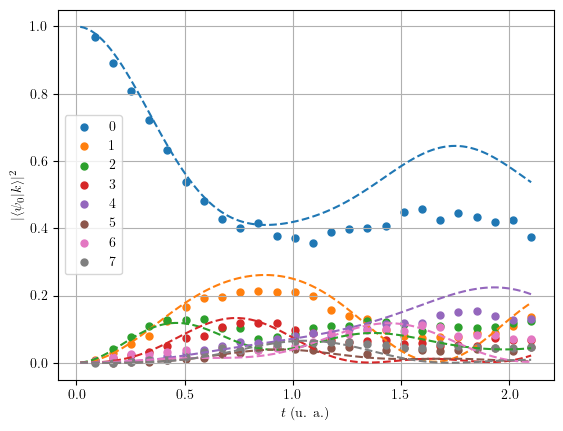

In [17]:
testAnalyzer.comparativeEvolution(
    STEPS=25,
    t=2.1,
    measurementFitter=measurementFitter
)


Using measurement error mitigation...
Implemented measurement error mitigation.


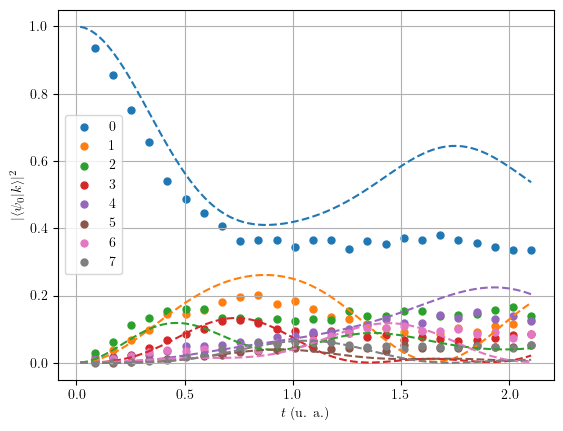

In [18]:
naiveAnalyzer.comparativeEvolution(
    STEPS=25,
    t=2.1,
    measurementFitter=measurementFitter
)

In [8]:
testErrorData = testAnalyzer.pdfErrorStepsData(
    MAX_STEPS=50,
    t=2.1,
    saveToFile=False,
    # measurementFitter=measurementFitter
)

In Counts2Pdf: Not using measurement error mitigation...


In [9]:
naiveErrorData = naiveAnalyzer.pdfErrorStepsData(
    MAX_STEPS=50,
    t=2.1,
    saveToFile=False,
    # measurementFitter=measurementFitter
)


In Counts2Pdf: Not using measurement error mitigation...


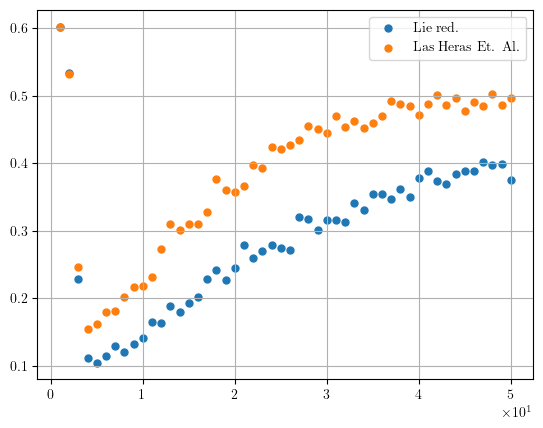

In [10]:
plt.scatter(*testErrorData, label="Lie red.")
plt.scatter(*naiveErrorData, label="Las Heras Et. Al.")
plt.legend()
plt.show()